## import Library

In [1]:
from typing import Callable, Optional
from pathlib import Path
import re

from PIL import Image
import numpy as np
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

SEED = 777

np.random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

## MNIST

## Data Structure

```text
.
<!-- ├── dataset
│   └── mnist -->
│       └── data_new
│           ├── 
│           │   ├── 0.jpg
│           │   ├── 1.jpg
│           │   ├── ...
│           │   └── 59999.jpg
│           └── label.txt
└── mnist_change.ipynb  (訓練 MNIST)
```


### Define Parameters

In [2]:
# device = 'cpu'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("device=",device)
DATASET_PATH = './fdata5'  # TODO: adjust path
# DATASET_PATH = './data_new'  # TODO: adjust path
# DATASET_PATH = './data_color'  # TODO: adjust path
# DATASET_PATH = './data_color2'  # TODO: adjust path

output_path = './model/hira_fdata5.pt'  # TODO: adjust path
epoch = 3000
batch_size = 512
learning_rate = 0.01
img_size=(83, 84)  # TODO: adjust img_size

device= cuda


In [3]:
import numpy as np
import cv2
import torch
from torchvision import transforms
from PIL import Image

from PIL import Image

def img_convert(input: np.ndarray) -> torch.Tensor: #回傳的是torch.Tensor，用於測試
    # 将图像转换为灰度影像
    gray_image = cv2.cvtColor(input, cv2.COLOR_BGR2GRAY)
    # 调整图像大小为 (83, 84)
    resized_image = cv2.resize(gray_image, (83, 84))

    equalized_image = cv2.equalizeHist(resized_image)

    # 多次侵蚀后膨胀
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
    eroded_image = cv2.erode(equalized_image, kernel, iterations=2)
    dilated_image = cv2.dilate(eroded_image, kernel, iterations=2)

    # 调整图像大小为 (83, 84)
    resized_image = cv2.resize(dilated_image, (83, 84))

    # 将图像转换为张量并调整形状
    tensor_image = transforms.ToTensor()(resized_image)
    # tensor_image = torch.unsqueeze(tensor_image, 0)

    return tensor_image


### Implement dataset class

In [4]:
class MnistDataset(Dataset):
    def __init__(self, path: str=f'/{DATASET_PATH}', data_transform: Optional[Callable]=None) -> None:
        super().__init__()
        self.dataset_path = Path(path)
        # self.data_transform = data_transform
        self.image, self.label = self.read_dataset()

        assert len(self.image) == len(self.label)
        self.length = len(self.image)

    def read_dataset(self):  # TODO: adjust this function
        image = dict()
        for path in self.dataset_path.joinpath('').glob('**/*'):
            if path.suffix in ['.jpg']:
                test_image = cv2.imread(str(path))  # 使用 cv2 讀取圖片
                converted_image = img_convert(test_image)  # 將圖片轉換成您需要的格式
                image[int(path.stem)] = np.array(converted_image)

                # image[int(path.stem)] = np.array(Image.open(path).copy())
        with open(self.dataset_path.joinpath('label.txt'), mode='r') as f:
            label = f.read().split("\n")  # 使用換行符分隔標籤
            label = [int(label) for label in label]

        return image, label

    def __getitem__(self, index):
        image, label = self.image[index], self.label[index]
        # 假设您直接在此处对图像进行转换
        # image = img_convert(image)
        image = torch.Tensor(image)
        return image, label

    def __len__(self):
        return self.length

### Implement model class

In [5]:
# class CNN(nn.Module):
#     def __init__(self, in_channels=1, out_num=50):  # adjust out_num to 50
#         super(CNN, self).__init__()

#         self.cnn1 = nn.Conv2d(in_channels=in_channels, out_channels=32, kernel_size=5, stride=1, padding=0) # out_shape=(32, 79, 80)
#         self.relu1 = nn.ReLU()
#         self.maxpool1 = nn.MaxPool2d(kernel_size=2) # out_shape=(32, 39, 40)

#         self.cnn2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5, stride=1, padding=0) # out_shape=(64, 35, 36)
#         self.relu2 = nn.ReLU()
#         self.maxpool2 = nn.MaxPool2d(kernel_size=2) # out_shape=(64, 17, 18)

#         self.fc1 = nn.Linear(in_features=64 * 17 * 18, out_features=out_num)  # adjust in_features based on the output shape of the last convolutional layer

#     def forward(self, x):
#         x = self.cnn1(x)
#         x = self.relu1(x)
#         x = self.maxpool1(x)

#         x = self.cnn2(x)
#         x = self.relu2(x)
#         x = self.maxpool2(x)

#         x = x.view(x.size(0), -1)
#         x = self.fc1(x)
#         return x
import torch.nn as nn

class CNN(nn.Module):
    def __init__(self, in_channels=1, out_num=50):
        super(CNN, self).__init__()

        self.cnn1 = nn.Conv2d(in_channels=in_channels, out_channels=64, kernel_size=5, stride=1, padding=0)
        self.relu1 = nn.ReLU()
        self.maxpool1 = nn.MaxPool2d(kernel_size=2)

        self.cnn2 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=5, stride=1, padding=0)
        self.relu2 = nn.ReLU()
        self.maxpool2 = nn.MaxPool2d(kernel_size=2)

        # Add a new hidden layer
        self.hidden_layer = nn.Linear(in_features=128 * 17 * 18, out_features=256)  # Adjust the number of output features as needed
        # self.dropout = nn.Dropout(0.01)  # Adjust the dropout rate as needed

        self.fc1 = nn.Linear(in_features=256, out_features=out_num)  # Adjust the input features based on the output shape of the hidden layer

    def forward(self, x):
        x = self.cnn1(x)
        x = self.relu1(x)
        x = self.maxpool1(x)

        x = self.cnn2(x)
        x = self.relu2(x)
        x = self.maxpool2(x)

        x = x.view(x.size(0), -1)

        # Pass through the hidden layer and apply dropout
        x = self.hidden_layer(x)
        # x = self.dropout(x)

        x = self.fc1(x)
        return x


### Build
(1)model, (2)loss-function, (3)optimizer, (4)dataloader

True or False

In [6]:
model_path = Path(output_path)  # TODO: adjust path
use_pretrained_model = True  # TODO: set True or False

In [7]:
# 檢查模型檔案是否存在
if model_path.exists() and use_pretrained_model:
    # 載入預訓練模型
    model = torch.jit.load(model_path, map_location=device).to(device)
    print('load model')
else:
    # 建立新模型
    model = CNN().to(device)
    print('set new model')

# loss function
criterion = nn.CrossEntropyLoss()
# optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

# data_transform = transforms.Compose([
#     transforms.Resize(img_size),
#     transforms.ToTensor(),   # [0, 1]
#     # transforms.Normalize((0.5), (0.5))  # [-1, 1]
# ])
dataset = MnistDataset(path=DATASET_PATH)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
model

set new model


CNN(
  (cnn1): Conv2d(1, 64, kernel_size=(5, 5), stride=(1, 1))
  (relu1): ReLU()
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (cnn2): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1))
  (relu2): ReLU()
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (hidden_layer): Linear(in_features=39168, out_features=256, bias=True)
  (fc1): Linear(in_features=256, out_features=50, bias=True)
)

In [8]:
def accuracy(pred: torch.Tensor, label: torch.Tensor):
    _, pred_label = pred.max(1)
    num_correct = (pred_label == label).sum().item()
    acc = num_correct / label.shape[0]
    return acc

### Training

In [9]:
training_choice = True

In [10]:
if training_choice == True:
    metric = {'loss': [], 'acc': []}
    for i_epoch in range(epoch):
        train_loss = []
        train_acc = []
        model.train(mode=True)
        for i_batch, (image, label) in enumerate(dataloader):
            image = image.to(device)
            label = label.to(device)

            pred = model.forward(image)  # inference

            loss = criterion(pred, label)  # calculate loss
            optimizer.zero_grad()  # reset gradient to zero
            loss.backward()  # calculate gradient
            optimizer.step()  # optimize weight (using gradient)

            train_loss += [loss.item()]
            train_acc += [accuracy(pred, label)]

        metric['loss'] += [sum(train_loss)/ len(dataloader)]
        metric['acc'] += [sum(train_acc)/ len(dataloader)]
        print(f'Epoch[{i_epoch+1}/{epoch}] loss: {metric["loss"][-1]}, acc: {metric["acc"][-1]}')
        if metric["acc"][-1] >= 1.0:  # 设定一个接近1的阈值
            print(f'Reached desired accuracy. Stopping training.')
            break

Epoch[1/3000] loss: 2.283818211790692, acc: 0.5648805353139014
Epoch[2/3000] loss: 1.2880408682363451, acc: 0.7988307525224215
Epoch[3/3000] loss: 1.2025850380482694, acc: 0.8137077844730941
Epoch[4/3000] loss: 1.1287590341450389, acc: 0.8233788186659193
Epoch[5/3000] loss: 1.0264995151571095, acc: 0.8325830297085202
Epoch[6/3000] loss: 0.8766365289153539, acc: 0.8430396931053811
Epoch[7/3000] loss: 0.7247693977682045, acc: 0.8541199551569507
Epoch[8/3000] loss: 0.6214639290565868, acc: 0.8662617362668161
Epoch[9/3000] loss: 0.5632272235748479, acc: 0.8750797015134529
Epoch[10/3000] loss: 0.5286210552192055, acc: 0.8809110496076232
Epoch[11/3000] loss: 0.505066721963241, acc: 0.88511596132287
Epoch[12/3000] loss: 0.4882740463242937, acc: 0.8884003643497758
Epoch[13/3000] loss: 0.4752057046366379, acc: 0.8903228349215246
Epoch[14/3000] loss: 0.46461463823179494, acc: 0.8923293862107624
Epoch[15/3000] loss: 0.4560605029621466, acc: 0.8940127522421525
Epoch[16/3000] loss: 0.44724314796817

KeyboardInterrupt: 

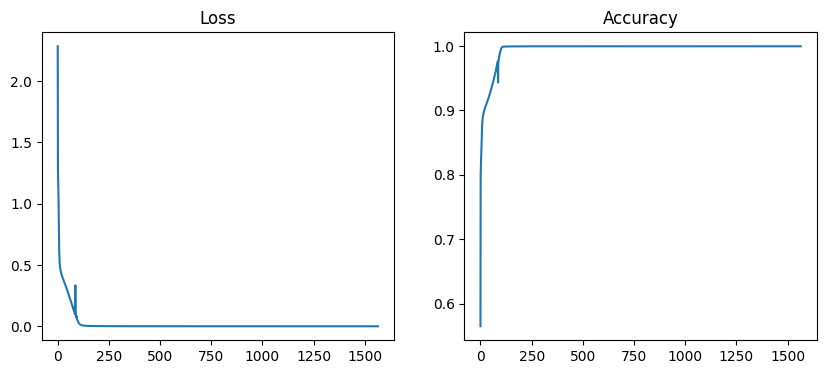

In [11]:
if training_choice == True:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
    ax1.plot(range(len(metric["loss"])), metric["loss"])
    ax1.set_title("Loss")
    ax2.plot(range(len(metric["acc"])), metric["acc"])
    ax2.set_title("Accuracy")
    plt.show()

### Save Model

In [12]:
model_path = Path(output_path)
model_path.parent.mkdir(parents=True, exist_ok=True)
torch.jit.script(model).save(model_path)

### Load Model

In [13]:
# model_path = Path('./model/hira.pt')  # TODO: adjust path
# assert model_path.exists() is True
# image_path = Path(f'./{DATASET_PATH}/99.jpg')  # TODO: adjust path
# assert image_path.exists() is True

# transform = transforms.Compose([
#     transforms.Resize((83, 84)),  # TODO: adjust img_size
#     transforms.ToTensor(),
# ])

# trained_model = torch.jit.load(model_path)
# test_image = Image.open(image_path)
# trans_image = img_convert(test_image)
# # trans_image = transform(test_image)

# pred = trained_model(trans_image.unsqueeze(0))
# pred_label = pred.max(1)[1]

# print(pred_label)
# test_image

#### ttttest

In [14]:
import numpy as np
import cv2
import torch
from torchvision import transforms
from pathlib import Path

from PIL import Image

def img_convert(input: np.ndarray) -> torch.Tensor: #回傳的是torch.Tensor，用於測試
    # 将图像转换为灰度影像
    gray_image = cv2.cvtColor(input, cv2.COLOR_BGR2GRAY)
    # 调整图像大小为 (83, 84)
    resized_image = cv2.resize(gray_image, (83, 84))

    equalized_image = cv2.equalizeHist(resized_image)

    # 多次侵蚀后膨胀
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
    eroded_image = cv2.erode(equalized_image, kernel, iterations=2)
    dilated_image = cv2.dilate(eroded_image, kernel, iterations=2)

    # 调整图像大小为 (83, 84)
    resized_image = cv2.resize(dilated_image, (83, 84))

    # 将图像转换为张量并调整形状
    tensor_image = transforms.ToTensor()(resized_image)
    # tensor_image = torch.unsqueeze(tensor_image, 0)

    return tensor_image



In [15]:
import os
import torch
from torchvision import transforms
from PIL import Image
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("device=",device)

model_path = Path(output_path, map_location=device)  # 請調整路徑
assert model_path.exists() is True

trained_model = torch.jit.load(model_path, map_location=device).to(device)

label_dict = {
    0: 'A', 1: 'BA', 2: 'CHI', 3: 'DA', 4: 'E', 5: 'FU', 6: 'HA', 7: 'HE', 8: 'HI', 9: 'HO', 10: 'I', 11: 'JI',
    12: 'KA', 13: 'KE', 14: 'KI', 15: 'KO', 16: 'KU', 17: 'MA', 18: 'ME', 19: 'MI', 20: 'MO', 21: 'MU', 22: 'N',
    23: 'NA', 24: 'NE', 25: 'NI', 26: 'NO', 27: 'NU', 28: 'O', 29: 'PI', 30: 'RA', 31: 'RE', 32: 'RI', 33: 'RO',
    34: 'RU', 35: 'SA', 36: 'SE', 37: 'SHI', 38: 'SO', 39: 'SU', 40: 'TA', 41: 'TE', 42: 'TO', 43: 'TSU', 44: 'U',
    45: 'WA', 46: 'WO', 47: 'YA', 48: 'YO', 49: 'YU'
}

trained_model


device= cuda


RecursiveScriptModule(
  original_name=CNN
  (cnn1): RecursiveScriptModule(original_name=Conv2d)
  (relu1): RecursiveScriptModule(original_name=ReLU)
  (maxpool1): RecursiveScriptModule(original_name=MaxPool2d)
  (cnn2): RecursiveScriptModule(original_name=Conv2d)
  (relu2): RecursiveScriptModule(original_name=ReLU)
  (maxpool2): RecursiveScriptModule(original_name=MaxPool2d)
  (hidden_layer): RecursiveScriptModule(original_name=Linear)
  (fc1): RecursiveScriptModule(original_name=Linear)
)

In [16]:
label_dict[0]

'A'

test path set

In [17]:
# test_data_path = 'fdata'
# test_data_path = 'data_new'
# test_data_path = 'data_color'
# test_data_path = 'data_color2'
# test_data_path = 'test_color'
test_data_path = 'testdata'

In [18]:
predictions = []
with open(f'{test_data_path}/label.txt', mode='r') as f:
    labels = f.read().split('\n')
labels = [label_dict[int(label)] for label in labels]


for i, label in enumerate(labels):
    image_path = f'{test_data_path}/{i}.jpg'  # 依據預設命名規則為每個圖片建立對應的路徑
    if os.path.exists(image_path):
        test_image = cv2.imread(image_path)  # 使用 cv2 讀取圖片
        converted_image = img_convert(test_image)  # 將圖片轉換成您需要的格式
        # trans_image = transform(converted_image)  # 應用其他轉換（如果需要）
        # pred = trained_model(trans_image.unsqueeze(0))
        pred = trained_model(converted_image.unsqueeze(0).to(device))
        pred_label = label_dict[pred.max(1)[1].item()]
        predictions.append((label, pred_label))

        if label != pred_label:
            print(f"预测错误的图像：{image_path}",end='\t')
            # plt.imshow(cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB))
            # plt.axis('off')
            # plt.show()

            print(f"真实标签：{label}",end='\t')
            print(f"预测标签：{pred_label}")
            print("-------------------------------------")
total = len(predictions)
correct = sum(1 for label, pred_label in predictions if label == pred_label)
accuracy = correct / total * 100
print(f"Accuracy: {accuracy:.2f}%")


预测错误的图像：testdata/145.jpg	真实标签：HE	预测标签：WA
-------------------------------------
预测错误的图像：testdata/219.jpg	真实标签：I	预测标签：SHI
-------------------------------------
Accuracy: 99.80%


result

In [19]:
import pandas as pd

# 创建一个空的数据帧
df = pd.DataFrame(index=label_dict.values(), columns=label_dict.values())
df = df.fillna(0)  # 将所有值初始化为0

# 计算正確值和預測值的交叉计数
for label, pred_label in predictions:
    df.loc[label, pred_label] += 1
pd.set_option('display.max_columns', None)
print(df)






      A  BA  CHI  DA   E  FU  HA  HE  HI  HO   I  JI  KA  KE  KI  KO  KU  MA  \
A    20   0    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   
BA    0  20    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   
CHI   0   0   20   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   
DA    0   0    0  20   0   0   0   0   0   0   0   0   0   0   0   0   0   0   
E     0   0    0   0  20   0   0   0   0   0   0   0   0   0   0   0   0   0   
FU    0   0    0   0   0  20   0   0   0   0   0   0   0   0   0   0   0   0   
HA    0   0    0   0   0   0  20   0   0   0   0   0   0   0   0   0   0   0   
HE    0   0    0   0   0   0   0  19   0   0   0   0   0   0   0   0   0   0   
HI    0   0    0   0   0   0   0   0  20   0   0   0   0   0   0   0   0   0   
HO    0   0    0   0   0   0   0   0   0  20   0   0   0   0   0   0   0   0   
I     0   0    0   0   0   0   0   0   0   0  19   0   0   0   0   0   0   0   
JI    0   0    0   0   0   0   0   0   0

In [20]:

# # 比對預測結果和真實標籤
# for label, pred_label in predictions:
#     if label == pred_label:
#         print(f'Label: {label}\tPrediction: {pred_label}\tCorrect')
total = len(predictions)
correct = sum(1 for label, pred_label in predictions if label == pred_label)
accuracy = correct / total * 100
print(f"Accuracy: {accuracy:.2f}%")

Accuracy: 99.80%
